# LIST OF IMPORTS

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
import logging
import time
import pickle
import seaborn as sns

%matplotlib inline

#Useful tools: 
#cols = ['station', 'C/A' ]
#pd.read_csv('file.ext', skipinitialspace = True, usecols = cols)
#Try pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt', % '170408')
#add pause to slow pinging using time.sleep(seconds)

#pd.concat

#response and request libraries

## FIRST DRAFTY STUFF

In [ ]:
# start_date = input('When would you like your canvassing project to begin? (mm/dd/yyyy)');

In [ ]:
# end_date = input('When is your event being held? (mm/dd/yyyy)')

In [ ]:
# def find_prev_saturday(date):
#     """Converts any given date to the previous Saturday from date
#     From this file names for MTA data (which is posted on Saturdays) can be automatically generated.
#     By choosing the previous Saturday, all dates are sure to be included."""
#     #Known_date is an arbitrarily chosen Saturday to check distance from input date
#     known_date = datetime.date(2017,4,8)
#     date = dateutil.parser.parse(date).date()
#     delta = datetime.timedelta(days = abs(getattr((date - known_date), 'days') % 7))
# #     date = date - delta
#     return date

In [ ]:
# def generate_mta_file_names(date1, date2, delta = datetime.timedelta(weeks = 52)):
#     """Takes a range of two dates and generates file name codes for pulling data files from the MTA websites
#     date1 and date2 must be in the format of """
#     start_date = find_prev_saturday(date1) - delta
#     end_date = find_prev_saturday(date2) - delta
#     date_array = []
#     add_week = datetime.timedelta(weeks = 1)
#     while start_date < end_date:
#         start_date = start_date + add_week
#         date_name = str(start_date)
#         date_code = date_name[2:4] + date_name[5:7] + date_name[8:]
#         date_array.append(date_code)
#     return date_array
# generate_mta_file_names(start_date, end_date)

In [ ]:
# ## MEANS OF TESTING FOR DUPLICATES
# #If true that means that there is at least 1 duplicate
# #Assumes that 'C/A' and 'SCP' are sufficient to idenitfy a unique turnstile
# def duplicate_test(df):
#     #Groupby 'C/A' and 'SCP' to find unique turnstile then count the # of Date_times, if date_time is repeated then return True
#     temp_df = df.groupby(['C/A','SCP'])['DATE_TIME'].value_counts() > 1
#     #If none of the values have more than 1 count return False and print 'no duplicates'
#     if len(temp_df[temp_df==True]) == 0:
#         print('No Duplicates!')
#     #eventually replace print codes with something that removes the duplicates.....
#     else:
#         print('Duplicate at: \n' + str(temp_df[temp_df==True]))


In [ ]:
# def pull_data_into_pandas(date1, date2):
#     """create an array of date codes from a start and end date and then pull data from web.mta.info"""
#     return None

# Functions

In [61]:
def is_weekday(date):
    """Takes a string or datetime.date object and returns True if it is a weekday and False if it is a weekend"""
    if type(date) != datetime.date:
        try:
            date = dateutil.parser.parse(date).date()
        except TypeError:
            logging.warning('Invalid input, cannot convert to datetime.')
            
    if date.weekday() < 5:
        weekday = True
    else:
        weekday = False
    return weekday

In [62]:
def clean_date(x):
    """Takes a string date and converts it to a datetime object"""
    return dateutil.parser.parse(x)

In [63]:
def complexity(num_turnstiles):
    """Assigns a complexity value to a station based on number of turnstiles
    Requires that NUM_TURNSTILES has been generated
    """
    if num_turnstiles < 10:
        complexity = 'LOW'
    elif num_turnstiles < 25:
        complexity = 'MEDIUM'
    elif num_turnstiles < 40:
        complexity = 'HIGH'
    else:
        complexity = 'EXTREME'
    return complexity

# CLEANING DATA

## LOAD DATA INTO KERNAL

In [82]:
"""THIS SECTION HAS BEEN COMMENTED OUT BECAUSE THE LOCAL COMPUTER ORIGINALLY USED NOW HAS PICKLE FILES

If you are executing this program for the first time uncomment this section"""

mta_data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_150307.txt')
# for n in ['150314','150321','150328','150404','150411',\
#           '150418','150425','150502','150509','150516','150523',\
#           '150530', '160305','160312','160319','160326','160402',\
#           '160409','160416','160423','160430','160514','160507', \
#           '160521', '160528','170304','170311','170318','170325','170401','170408']:
#     mta_data_temp = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_%s.txt' % (n))
#     dfs = [mta_data,mta_data_temp]
#     mta_data = pd.concat(dfs, axis = 0)
#     time.sleep(10)



In [83]:
# pickle.dump( mta_data, open( "mta_data.p", "wb" ) )

In [84]:
# mta_data = pickle.load( open( "mta_data.p", "rb" ) )

## Remove blank spaces in column names, add 'DATE_TIME', 'IS_WEEKDAY', 'TURNSTILE', and  'NUM_TURNSTILES', remove RECOVER AUD, and remove unnecessary columns:

In [85]:
#Remove blank spaces in columns
mta_data.rename(columns=lambda x: x.strip(), inplace=True)

In [86]:
mta_data['IS_WEEKDAY'] = mta_data['DATE'].apply(is_weekday)

mta_data['DATE_TIME']= mta_data['DATE'] + ' ' + mta_data['TIME']

mta_data['DATE'] = mta_data['DATE'].apply(clean_date);
mta_data['DATE_TIME'] = mta_data['DATE_TIME'].apply(clean_date);

mta_data['TURNSTILE'] = mta_data['C/A'] + ' ' + mta_data['SCP']

mta_data2 = mta_data.groupby('STATION')['TURNSTILE'].nunique()
mta_data2 = mta_data2.to_frame()
mta_data2.reset_index(inplace=True)

mta_data = pd.merge(mta_data,mta_data2,on='STATION', how='left')

mta_data.rename(columns={'TURNSTILE_x': 'TURNSTILE', 'TURNSTILE_y': 'NUM_TURNSTILES'}, inplace=True)

mta_data['STATION_COMPLEXITY'] = mta_data['NUM_TURNSTILES'].apply(complexity)

mta_data.query("DESC == 'REGULAR'", inplace = True)

#Remove unnessecary columns
del mta_data['DIVISION']
del mta_data['C/A']
del mta_data['SCP']
del mta_data['UNIT']
mta_data = mta_data.query('STATION != "TIMES SQ-42 ST"')


In [87]:
#Pickle cleaned data in case of kernal restart
pickle.dump( mta_data, open( "mta_data_cleaned.p", "wb" ) )

## Calculate New Foot Traffic and Eliminate Outliers

In [88]:

#Calculate new entries, new exits, and total foot traffic
mta_data_sorted = mta_data.sort_values(['TURNSTILE', 'DATE'], ascending=[True, True])
mta_data_sorted['ENTRIES_NEXT'] = mta_data_sorted['ENTRIES'].shift(-1)
mta_data_sorted['NEW_ENTRIES'] = mta_data_sorted['ENTRIES_NEXT'] - mta_data_sorted['ENTRIES']

mta_data_sorted['EXITS_NEXT'] = mta_data_sorted['EXITS'].shift(-1)
mta_data_sorted['NEW_EXITS'] = mta_data_sorted['EXITS_NEXT'] - mta_data_sorted['EXITS']


mta_data_sorted['TURNSTILE_NEXT'] = mta_data_sorted['TURNSTILE'].shift(-1)
mta_data_sorted['TURNSTILE_NOT_SAME'] = mta_data_sorted['TURNSTILE'] != mta_data_sorted['TURNSTILE_NEXT']

#Remove False Data (negatives, extremes)
mta_data_sorted = mta_data_sorted.query('TURNSTILE_NOT_SAME == False')
mta_data_sorted = mta_data_sorted.query('NEW_ENTRIES > 0')
mta_data_sorted = mta_data_sorted.query('NEW_EXITS > 0')

mta_data_sorted = mta_data_sorted.query('NEW_ENTRIES < 10000')
mta_data_sorted = mta_data_sorted.query('NEW_EXITS < 10000')

#Calc Foot Traffic
mta_data_sorted['FOOT_TRAFFIC'] = mta_data_sorted['NEW_ENTRIES'] + mta_data_sorted['NEW_EXITS']

## Taking Foot Traffic Averages by station for weekdays only

In [89]:
mta_weekday = mta_data_sorted.query('IS_WEEKDAY == True')

mta_foot_traf_av = mta_weekday.groupby('STATION')['FOOT_TRAFFIC'].mean()
mta_foot_traf_av = mta_foot_traf_av.to_frame()
mta_foot_traf_av.reset_index(inplace = True)
mta_foot_traf_av =mta_foot_traf_av.sort_values('FOOT_TRAFFIC', ascending = False)

mta_weekday = pd.merge(mta_weekday,mta_foot_traf_av,on='STATION', how='left', suffixes=['','_AVG'])
mta_weekday = mta_weekday.sort_values(['FOOT_TRAFFIC', 'STATION'], ascending=[False, False])
mta_weekday = mta_weekday.sort_values('FOOT_TRAFFIC_AVG', ascending=False).drop_duplicates('STATION', keep='first')

# PLOTTING DATA

## Testing to see where 'real data' cutoff is for number of new entries

In [90]:
mta_weekday['NEW_ENTRIES'].max()

4862.0

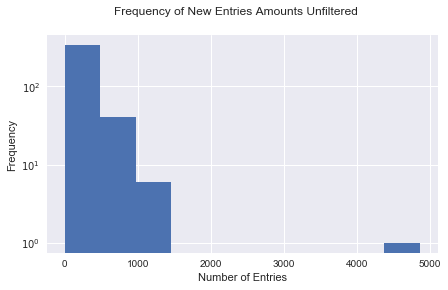

In [91]:
fig, ax = plt.subplots(1,1,figsize =(7,4))
fig.suptitle('Frequency of New Entries Amounts Unfiltered', fontsize='large')
plt.xlabel('Number of Entries')
plt.ylabel('Frequency')
plt.yscale('log')
plt.hist(mta_weekday['NEW_ENTRIES'])
plt.show()

In [92]:
mta_weekday = mta_weekday.query('NEW_ENTRIES < 10000')

In [93]:
mta_weekday[['STATION','NEW_ENTRIES', 'TIME']].sort_values('NEW_ENTRIES',ascending=False).head(5)

,STATION,NEW_ENTRIES,TIME
7425,7 AVE,4862.0,07:40:27
67135,TWENTY THIRD ST,1309.0,15:16:34
65574,CITY / BUS,1307.0,07:23:06
20543,MARCY AVE,1074.0,08:00:00
36120,HOYT/SCHERMER,986.0,11:00:00


## Graphing Avg Foot Traffic by Station

In [94]:
def merge_station(v):
    if v == 'GRD CNTRL-42 ST':
        v = '42 ST-GRD CNTRL'    
    elif v == '149/GRAND CONC':
        v = '149 ST-GR CONC'
    elif v == '1 AV':
        v = '1 AVE'
    else:
        v = v
    return v


mta_weekday['STATION'] = mta_weekday['STATION'].apply(merge_station)
mta_weekday

,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,IS_WEEKDAY,DATE_TIME,TURNSTILE,NUM_TURNSTILES,STATION_COMPLEXITY,ENTRIES_NEXT,NEW_ENTRIES,EXITS_NEXT,NEW_EXITS,TURNSTILE_NEXT,TURNSTILE_NOT_SAME,FOOT_TRAFFIC,FOOT_TRAFFIC_AVG
7425,7 AVE,BQ,2015-03-04,07:40:27,REGULAR,3231,4039,True,2015-03-04 07:40:27,B004 00-00-03,4,LOW,8093.0,4862.0,7278.0,3239.0,B004 00-00-03,False,8101.0,1318.611940
56239,23 ST-6 AVE,FM,2015-03-03,07:00:00,REGULAR,336201700,319366229,True,2015-03-03 07:00:00,N508 00-00-03,10,MEDIUM,336201833.0,133.0,319367196.0,967.0,N508 00-00-03,False,1100.0,994.490347
91214,149 ST-GR CONC,245,2015-03-04,03:00:00,REGULAR,363036,574463,True,2015-03-04 03:00:00,R261 00-00-00,7,LOW,363111.0,75.0,574549.0,86.0,R261 00-00-00,False,161.0,927.053846
58554,YORK ST,F,2015-03-06,04:00:00,REGULAR,10500772,5704433,True,2015-03-06 04:00:00,N530 00-00-01,3,LOW,10500988.0,216.0,5704567.0,134.0,N530 00-00-01,False,350.0,917.034483
83898,14 ST-UNION SQ,456LNQR,2015-03-06,12:00:00,REGULAR,1120978,3187881,True,2015-03-06 12:00:00,R221 01-03-02,38,HIGH,1121807.0,829.0,3188873.0,992.0,R221 01-03-02,False,1821.0,914.958209
86113,42 ST-GRD CNTRL,4567S,2015-03-05,19:00:00,REGULAR,1365672,4235562,True,2015-03-05 19:00:00,R238 00-00-01,62,EXTREME,1365933.0,261.0,4236060.0,498.0,R238 00-00-01,False,759.0,911.780935
17548,1 AVE,L,2015-03-04,11:00:00,REGULAR,1213201,479962,True,2015-03-04 11:00:00,H007 00-03-01,10,MEDIUM,1213373.0,172.0,480013.0,51.0,H007 00-03-01,False,223.0,867.541850
32730,W 4 ST-WASH SQ,ABCDEFM,2015-03-06,12:00:00,REGULAR,17459,4718,True,2015-03-06 12:00:00,N083 01-02-02,19,MEDIUM,17780.0,321.0,4861.0,143.0,N083 01-02-02,False,464.0,851.174009
98623,WESTCHESTER SQ,6,2015-03-04,11:00:00,REGULAR,9725742,8902472,True,2015-03-04 11:00:00,R420 00-00-01,3,LOW,9726211.0,469.0,8902859.0,387.0,R420 00-00-01,False,856.0,828.425287
91947,BURNSIDE AVE,4,2015-03-02,23:00:00,REGULAR,3503017,1910985,True,2015-03-02 23:00:00,R287 00-00-00,5,LOW,3503088.0,71.0,1911144.0,159.0,R287 00-00-00,False,230.0,821.532609


In [100]:
mta_weekday_combine_streets = mta_weekday.groupby('STATION')['FOOT_TRAFFIC_AVG'].mean()
mta_weekday_combine_streets = mta_weekday_combine_streets.to_frame()
mta_weekday_combine_streets.reset_index(inplace = True)
mta_weekday_combine_streets = mta_weekday_combine_streets.sort_values('FOOT_TRAFFIC_AVG', ascending = False)


In [95]:
# complexity_data = pd.merge(mta_weekday_combine_streets, mta_weekday, on='STATION', how = 'left')
# complexity_data.drop_duplicates('STATION', inplace= True)

In [96]:
# complexity_data.head(25)

,STATION,FOOT_TRAFFIC_AVG_x,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,IS_WEEKDAY,DATE_TIME,...,NUM_TURNSTILES,STATION_COMPLEXITY,ENTRIES_NEXT,NEW_ENTRIES,EXITS_NEXT,NEW_EXITS,TURNSTILE_NEXT,TURNSTILE_NOT_SAME,FOOT_TRAFFIC,FOOT_TRAFFIC_AVG_y
0,7 AVE,1318.611940,BQ,2015-03-04,07:40:27,REGULAR,3231,4039,True,2015-03-04 07:40:27,...,4,LOW,8093.0,4862.0,7278.0,3239.0,B004 00-00-03,False,8101.0,1318.611940
1,23 ST-6 AVE,994.490347,FM,2015-03-03,07:00:00,REGULAR,336201700,319366229,True,2015-03-03 07:00:00,...,10,MEDIUM,336201833.0,133.0,319367196.0,967.0,N508 00-00-03,False,1100.0,994.490347
2,149 ST-GR CONC,927.053846,245,2015-03-04,03:00:00,REGULAR,363036,574463,True,2015-03-04 03:00:00,...,7,LOW,363111.0,75.0,574549.0,86.0,R261 00-00-00,False,161.0,927.053846
3,YORK ST,917.034483,F,2015-03-06,04:00:00,REGULAR,10500772,5704433,True,2015-03-06 04:00:00,...,3,LOW,10500988.0,216.0,5704567.0,134.0,N530 00-00-01,False,350.0,917.034483
4,14 ST-UNION SQ,914.958209,456LNQR,2015-03-06,12:00:00,REGULAR,1120978,3187881,True,2015-03-06 12:00:00,...,38,HIGH,1121807.0,829.0,3188873.0,992.0,R221 01-03-02,False,1821.0,914.958209
5,42 ST-GRD CNTRL,911.780935,4567S,2015-03-05,19:00:00,REGULAR,1365672,4235562,True,2015-03-05 19:00:00,...,62,EXTREME,1365933.0,261.0,4236060.0,498.0,R238 00-00-01,False,759.0,911.780935
6,1 AVE,867.541850,L,2015-03-04,11:00:00,REGULAR,1213201,479962,True,2015-03-04 11:00:00,...,10,MEDIUM,1213373.0,172.0,480013.0,51.0,H007 00-03-01,False,223.0,867.541850
7,W 4 ST-WASH SQ,851.174009,ABCDEFM,2015-03-06,12:00:00,REGULAR,17459,4718,True,2015-03-06 12:00:00,...,19,MEDIUM,17780.0,321.0,4861.0,143.0,N083 01-02-02,False,464.0,851.174009
8,WESTCHESTER SQ,828.425287,6,2015-03-04,11:00:00,REGULAR,9725742,8902472,True,2015-03-04 11:00:00,...,3,LOW,9726211.0,469.0,8902859.0,387.0,R420 00-00-01,False,856.0,828.425287
9,BURNSIDE AVE,821.532609,4,2015-03-02,23:00:00,REGULAR,3503017,1910985,True,2015-03-02 23:00:00,...,5,LOW,3503088.0,71.0,1911144.0,159.0,R287 00-00-00,False,230.0,821.532609


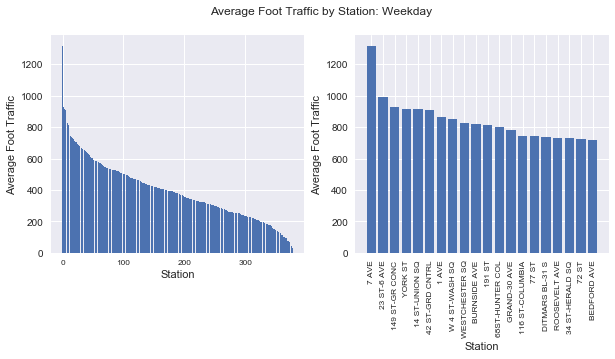

In [101]:
#AVERAGE FOOT TRAFFIC BY STATION WEEKDAY

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Average Foot Traffic by Station: Weekday", fontsize="large")

mta_weekday_station_names = []
for k,v in mta_weekday_combine_streets['STATION'].items():
    mta_weekday_station_names.append(v)
plot_one_xticks = mta_weekday_station_names[::50]

ax[0].set_xlabel('Station')
ax[0].set_ylabel('Average Foot Traffic')
plt.sca(ax[0])
plt.xticks(size='small', rotation='horizontal')
stations = range(len(mta_weekday['STATION']))
foot_traf = mta_weekday['FOOT_TRAFFIC_AVG']
ax[0].bar(stations, foot_traf)

ax[1].set_xlabel('Station')
ax[1].set_ylabel('Average Foot Traffic')
plt.sca(ax[1])
plt.xticks(range(20), mta_weekday_station_names, size='small', rotation='vertical')
stations = range(20)
foot_traf2 = mta_weekday_combine_streets['FOOT_TRAFFIC_AVG'][:20]
ax[1].bar(stations, foot_traf2);



In [102]:
mta_weekday_combine_streets.head(5)

,STATION,FOOT_TRAFFIC_AVG
101,7 AVE,1318.611940
54,23 ST-6 AVE,994.490347
22,149 ST-GR CONC,927.053846
378,YORK ST,917.034483
18,14 ST-UNION SQ,914.958209


In [105]:
mta_weekday.head()

,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,EXITS,IS_WEEKDAY,DATE_TIME,TURNSTILE,NUM_TURNSTILES,STATION_COMPLEXITY,ENTRIES_NEXT,NEW_ENTRIES,EXITS_NEXT,NEW_EXITS,TURNSTILE_NEXT,TURNSTILE_NOT_SAME,FOOT_TRAFFIC,FOOT_TRAFFIC_AVG
7425,7 AVE,BQ,2015-03-04,07:40:27,REGULAR,3231,4039,True,2015-03-04 07:40:27,B004 00-00-03,4,LOW,8093.0,4862.0,7278.0,3239.0,B004 00-00-03,False,8101.0,1318.611940
56239,23 ST-6 AVE,FM,2015-03-03,07:00:00,REGULAR,336201700,319366229,True,2015-03-03 07:00:00,N508 00-00-03,10,MEDIUM,336201833.0,133.0,319367196.0,967.0,N508 00-00-03,False,1100.0,994.490347
91214,149 ST-GR CONC,245,2015-03-04,03:00:00,REGULAR,363036,574463,True,2015-03-04 03:00:00,R261 00-00-00,7,LOW,363111.0,75.0,574549.0,86.0,R261 00-00-00,False,161.0,927.053846
58554,YORK ST,F,2015-03-06,04:00:00,REGULAR,10500772,5704433,True,2015-03-06 04:00:00,N530 00-00-01,3,LOW,10500988.0,216.0,5704567.0,134.0,N530 00-00-01,False,350.0,917.034483
83898,14 ST-UNION SQ,456LNQR,2015-03-06,12:00:00,REGULAR,1120978,3187881,True,2015-03-06 12:00:00,R221 01-03-02,38,HIGH,1121807.0,829.0,3188873.0,992.0,R221 01-03-02,False,1821.0,914.958209
